# Дорогой дневник

--------------------------------------------

1) Сначала я решил попробовать без генерации новых фичей и без подкрутки параметров запустить LightGBM и посмотреть, что будет. Скор 0.720
При этом пока еще нет ни генерации новых признаков, ни использования таблицы поиска и тд. Попробуем добавить.

2) Просто запускаем код из "baseline_1_pandas.ipynb" и получаем обещаный скор 0.817

3) Оптюнил 10 минут, безрезультатно. Буду придумывать новые признаки. Думаю начать с кластеризации и knn. 

4) Сначала решил просто расширить плавающее окно с 4 до 5 месяцев, результат 0.8192.

    Есть огромное количество идей, только что заменил пандас на поларс, потому что он реально на порядок быстрее. В первую очередь хочется применить знания с семинара по интерпретации бустингов, но сначала заменить катбуст на lgbm, ибо Илья утверждал, что при должном обращении он рвет и мечет.

--------------------------------------------

# Другой подход к кластеризации

Пробуем новую идею, если не получается кластеризовать все обьекты, будем делать так: мы же уже знаем какие есть кластеры, просто раздадим метки по ключевым словам, олценим сколько осталось и проведем еще одну кластеризацию. 

In [111]:
import polars as pl
import pandas as pd
import numpy as np
import catboost
import os
from datetime import date, timedelta
from itertools import combinations

from local_utils import *
import lightgbm as lgb

%load_ext autoreload
%autoreload 2

test_start_date = date(2024, 8, 1)
val_start_date = date(2024, 7, 1)
val_end_date = date(2024, 7, 31)
train_end_date = date(2024, 6, 30)
data_path = "C:\\Users\\Admin\\Desktop\\AIM 2сем\\ML2\\hw2"

actions_history = pl.scan_parquet(os.path.join(data_path, 'actions_history/*.parquet')).collect()
search_history = pl.scan_parquet(os.path.join(data_path, 'cluster_search/*.parquet')).collect()
widget_info = pl.read_csv(os.path.join(data_path, 'widget_info.csv'))
product_information = pl.read_csv(
    os.path.join(data_path, 'cluster_product_information.csv'),
    ignore_errors=True
)

val_target = (
    actions_history
    .filter(pl.col('timestamp').dt.date() >= val_start_date)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .select('user_id', (pl.col('action_type_id') == 3).alias('has_order'))
    .group_by('user_id')
    .agg(pl.max('has_order').cast(pl.Int32).alias('target'))
)

val_target.group_by('target').agg(pl.count('user_id'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


target,user_id
i32,u32
0,1227381
1,647575


In [112]:
actions_aggs = {}
actions_id_to_suf = {
    1: "click",
    2: "favorite", 
    3: "order",
    5: "to_cart",
}

# Сначала соберем все агрегированные данные
all_aggs = []
numeric_features = []

for id_, suf in actions_id_to_suf.items():
    aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= train_end_date)
        .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5))
        .filter(pl.col('action_type_id') == id_)
        .join(
            product_information.select('product_id', 'discount_price'),
            on='product_id',
        )
        .group_by('user_id')
        .agg(
            pl.count('product_id').cast(pl.Int32).alias(f'num_products_{suf}'),
            pl.sum('discount_price').cast(pl.Float32).alias(f'sum_discount_price_{suf}'),
            pl.max('discount_price').cast(pl.Float32).alias(f'max_discount_price_{suf}'),
            pl.max('timestamp').alias(f'last_{suf}_time'),
            pl.min('timestamp').alias(f'first_{suf}_time'),
        )
        .with_columns([
            (pl.lit(val_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),
            
            (pl.lit(val_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
        ])
    )
    
    # Сохраняем имена числовых фичей для последующего создания полиномов
    numeric_features.extend([
        f'num_products_{suf}',
        f'sum_discount_price_{suf}', 
        f'max_discount_price_{suf}',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
    ])
    
    actions_aggs[id_] = aggs
    all_aggs.append(aggs)

# Объединяем все агрегации по user_id с указанием суффиксов
combined = all_aggs[0]
for i, agg in enumerate(all_aggs[1:], 1):
    combined = combined.join(
        agg, 
        on='user_id', 
        how='left',
        suffix=f"_{i}"  # Добавляем уникальный суффикс для каждого соединения
    )

In [113]:
# search_aggs
id_ = 4
suf = 'search'

# Сначала вычислим value_counts отдельно и развернем их в плоскую структуру
cluster_counts = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= train_end_date)
    .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        pl.col('cluster').value_counts().alias('cluster_counts')
    )
    .explode('cluster_counts')
    .with_columns(
        pl.col('cluster_counts').struct.field('cluster').alias('cluster_name'),
        pl.col('cluster_counts').struct.field('count').alias('cluster_count')
    )
    .group_by('user_id')
    .agg(
        pl.col('cluster_name').sort_by('cluster_count', descending=True).head(3).alias('top3_clusters'),
        pl.col('cluster_count').sort(descending=True).head(3).alias('top3_counts')
    )
)

actions_aggs[id_] = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= train_end_date)
    .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        # Общее количество поисков за 5 месяцев
        pl.count('search_query').cast(pl.Int32).alias(f'num_{suf}'),
        pl.col('search_query').n_unique().alias(f'unique_{suf}_queries'),
        
        # Количество поисков за последний месяц (30 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_month'),
        
        # Количество поисков за последнюю неделю (7 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=7))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_week'),

        (pl.count() / (pl.max('timestamp') - pl.min('timestamp')).dt.total_days()).alias(f'{suf}_daily_rate'),

        pl.col('cluster').n_unique().alias(f'num_{suf}_clusters'),
        pl.col('cluster').mode().first().alias(f'main_{suf}_cluster'),
        
        # Динамика кластеров
        pl.col('cluster')
            .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30))
            .mode().first()
            .alias(f'recent_{suf}_cluster'),

        (pl.col('cluster').value_counts().struct.field('count').max() / pl.col('cluster').count()).alias(f'{suf}_cluster_concentration'),
        
        # Энтропия кластеров (мера разнообразия)
        (-(pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count()).log()
            * (pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count())
            .sum()).alias(f'{suf}_cluster_entropy'),
        
        # Переключения между кластерами
        pl.col('cluster').diff().fill_null(0).abs().sum().alias(f'{suf}_cluster_switches'),
        
        # Стабильность кластеров (процент повторяющихся)
        ((pl.col('cluster').count() - pl.col('cluster').n_unique()) / pl.col('cluster').count())
            .alias(f'{suf}_cluster_stability'),
        
        # Время в основном кластере
        (pl.col('timestamp')
            .filter(pl.col('cluster') == pl.col('cluster').mode().first())
            .count() / pl.col('timestamp').count())
            .alias(f'main_{suf}_cluster_time_ratio'),

        pl.col('timestamp').filter(pl.col('cluster').diff().fill_null(0) != 0)
            .diff()
            .dt.total_days()
            .mean()
            .alias(f'{suf}_mean_cluster_switch_days'),

        pl.col('search_query').str.len_chars().mean().alias(f'{suf}_mean_query_len'),
        
        (pl.col('search_query').str.len_chars()
            .filter(pl.col('cluster') == pl.col('cluster').mode().first()).mean() - 
            pl.col('search_query').str.len_chars()
                .filter(pl.col('cluster') != pl.col('cluster').mode().first()).mean())
                .alias(f'{suf}_main_cluster_query_len_diff'),

        pl.max('timestamp').alias(f'last_{suf}_time'),
        pl.min('timestamp').alias(f'first_{suf}_time'),
    )
    .join(cluster_counts, on='user_id', how='left')
    .with_columns([
        (pl.lit(val_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),

        (pl.lit(val_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
    ])
    .select(
        'user_id',
        f'num_{suf}',
        f'unique_{suf}_queries',
        f'num_{suf}_last_month',
        f'num_{suf}_last_week',
        f'{suf}_daily_rate',
        f'num_{suf}_clusters',
        f'main_{suf}_cluster',
        pl.col('top3_clusters').alias(f'top3_{suf}_clusters'),
        pl.col('top3_counts').alias(f'top3_{suf}_counts'),
        f'recent_{suf}_cluster',
        f'{suf}_cluster_concentration',
        f'{suf}_cluster_entropy',
        f'{suf}_cluster_switches',
        f'{suf}_cluster_stability',
        f'main_{suf}_cluster_time_ratio',
        f'{suf}_mean_cluster_switch_days',
        f'{suf}_mean_query_len',
        f'{suf}_main_cluster_query_len_diff',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
        f'last_{suf}_time',
        f'first_{suf}_time',
    )
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_141116\276488151.py:52: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.



In [114]:
product_cluster_aggs = (
    actions_history
    .filter(pl.col('timestamp').dt.date() <= train_end_date)
    .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5))
    .join(
        product_information.select('product_id', 'cluster'),
        on='product_id'
    )
    .group_by('user_id')
    .agg(
        # Общие агрегаты по кластерам продуктов
        pl.col('cluster').n_unique().alias('num_product_clusters'),
        pl.col('cluster').mode().first().alias('main_product_cluster'),
        
        # Аналогичные агрегаты как для search
        (pl.col('cluster').value_counts().struct.field('count').max() / pl.col('cluster').count()).alias('product_cluster_concentration'),
        
        # Энтропия кластеров продуктов
        (-(pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count()).log()
            * (pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count())
            .sum()).alias('product_cluster_entropy'),
        
        # Стабильность кластеров продуктов
        ((pl.col('cluster').count() - pl.col('cluster').n_unique()) / pl.col('cluster').count())
            .alias('product_cluster_stability'),
        
        # Время в основном кластере продуктов
        (pl.col('timestamp')
            .filter(pl.col('cluster') == pl.col('cluster').mode().first())
            .count() / pl.col('timestamp').count()
        ).alias('main_product_cluster_time_ratio'),
            
        # Top 3 кластеров продуктов
        pl.col('cluster').value_counts().struct.field('cluster').alias('top_product_clusters'),
        pl.col('cluster').value_counts().struct.field('count').alias('top_product_counts')
    )
    .with_columns(
        pl.col('top_product_clusters').list.head(3).alias('top3_product_clusters'),
        pl.col('top_product_counts').list.head(3).alias('top3_product_counts')
    )
    .drop(['top_product_clusters', 'top_product_counts'])
)

In [115]:
train_last_month_features = (
    actions_history
    .filter(
        (pl.col('timestamp').dt.date() < val_start_date) &  # до валидации
        (pl.col('timestamp').dt.date() >= val_start_date - timedelta(days=30))  # последние 30 дней
    )
    .join(
        product_information.select('product_id', 'discount_price', 'cluster'),
        on='product_id'
    )
    .group_by('user_id')
    .agg(
        # Общая активность
        pl.count().alias('total_actions_30d'),
        
        # Разбивка по типам действий
        (pl.col('action_type_id') == 1).sum().alias('clicks_30d'),
        (pl.col('action_type_id') == 2).sum().alias('favorites_30d'),
        (pl.col('action_type_id') == 5).sum().alias('cart_adds_30d'),
        
        # Финансовые метрики
        pl.sum('discount_price').alias('total_spent_30d'),
        pl.mean('discount_price').alias('avg_price_30d'),
        
        # Временные характеристики (исправлено!)
        (val_start_date - pl.col('timestamp').max().dt.date()).dt.total_days().alias('days_since_last_action'),
        (pl.col('timestamp').max() - pl.col('timestamp').min()).dt.total_days().alias('active_days_30d'),
        
        # Метрики кластеров
        pl.col('cluster').n_unique().alias('unique_clusters_30d'),
        (pl.col('cluster').value_counts().struct.field('count').max() / pl.count()).alias('main_cluster_ratio_30d')
    )
    .with_columns(
        # Производные признаки
        (pl.col('total_actions_30d') / pl.col('active_days_30d')).alias('daily_actions_rate_30d'),
        (pl.col('cart_adds_30d') / pl.col('total_actions_30d')).alias('cart_add_ratio_30d'),
        (pl.col('favorites_30d') / pl.col('total_actions_30d')).alias('favorite_ratio_30d')
    )
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_141116\1964511306.py:14: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.

C:\Users\Admin\AppData\Local\Temp\ipykernel_141116\1964511306.py:31: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.



In [116]:
# Виджеты
existing_widgets = (
    actions_history
    .filter(pl.col('widget_name_id').is_not_null())
    .select(pl.col('widget_name_id').unique())
    .to_series()
    .to_list()
)

# Теперь создаем агрегаты только для существующих виджетов
widget_aggs = (
    actions_history
    .filter(
        (pl.col('timestamp').dt.date() <= train_end_date) &
        (pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5)) &
        (pl.col('widget_name_id').is_not_null())
    )
    .group_by(['user_id', 'widget_name_id'])
    .agg(
        pl.count().alias('widget_count')
    )
    .join(
        actions_history
        .filter(
            (pl.col('timestamp').dt.date() <= train_end_date) &
            (pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5)) &
            (pl.col('widget_name_id').is_not_null())
        )
        .group_by('user_id')
        .agg(pl.count().alias('total_widget_actions')),
        on='user_id'
    )
    .with_columns(
        (pl.col('widget_count') / pl.col('total_widget_actions')).alias('widget_ratio')
    )
    .group_by('user_id')
    .agg([
        *[pl.col('widget_count').filter(pl.col('widget_name_id') == widget_id).first().alias(f'widget_{widget_id}_count') 
          for widget_id in existing_widgets],
        *[pl.col('widget_ratio').filter(pl.col('widget_name_id') == widget_id).first().alias(f'widget_{widget_id}_ratio') 
          for widget_id in existing_widgets]
    ])
    .fill_null(0)
)

if 'total_widget_actions' in widget_aggs.columns:
    widget_aggs = widget_aggs.drop('total_widget_actions')

C:\Users\Admin\AppData\Local\Temp\ipykernel_141116\790935654.py:20: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.

C:\Users\Admin\AppData\Local\Temp\ipykernel_141116\790935654.py:30: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.



In [ ]:
df_main = val_target
for _, actions_aggs_df in actions_aggs.items():
    df_main = (
        df_main
        .join(actions_aggs_df, on='user_id', how='left')
    )

df_main = df_main.join(product_cluster_aggs, on='user_id', how='left')
df_main = df_main.join(train_last_month_features, on='user_id', how='left')
df_main = df_main.join(widget_aggs, on='user_id', how='left')

df_pd = df_main.to_pandas()

columns_to_log = ['max_discount_price_click', 'num_products_favorite', 'sum_discount_price_favorite', 'max_discount_price_favorite',  'num_products_order', 'sum_discount_price_order', 'sum_discount_price_order',  'num_products_to_cart', 'max_discount_price_to_cart', 'num_search', 'unique_search_queries', 'num_search_last_week', 'search_daily_rate', 'search_cluster_switches', 'search_mean_query_len', 'search_main_cluster_query_len_diff']

df_pd = apply_log_transform(df_pd, columns_to_log, drop_original=True)

In [118]:
from local_utils import *

knn_cols = ['log_sum_discount_price_order', 'sum_discount_price_to_cart', 'product_cluster_stability', 'log_num_products_order', 'product_cluster_concentration',  'days_since_first_order', 'days_since_last_order', 
            'widget_5_ratio', 'widget_14_ratio', 'widget_6_ratio', 'widget_3_ratio', 'widget_12_ratio', 'widget_16_ratio', 'widget_15_ratio', 'cart_adds_30d']

#df_pd = add_knn_features_faiss(df_pd, knn_cols, n_neighbors=4, use_gpu=True)

In [119]:
def add_time_pattern_features(df_pd, actions_history, product_info):
    # Конвертируем product_info в LazyFrame если нужно
    product_info_lazy = product_info.lazy() if isinstance(product_info, pl.DataFrame) else product_info
    
    time_aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= train_end_date)
        .with_columns([
            ((pl.col('timestamp').dt.hour() >= 6) & (pl.col('timestamp').dt.hour() < 12)).alias('new_is_morning'),
            ((pl.col('timestamp').dt.hour() >= 12) & (pl.col('timestamp').dt.hour() < 18)).alias('new_is_day'),
            (pl.col('timestamp').dt.weekday() >= 5).alias('new_is_weekend'),
            (pl.col('timestamp').dt.hour()).alias('new_hour'),
            (pl.col('timestamp').dt.weekday()).alias('new_dow')
        ])
        .join(
            product_info_lazy.select(['product_id', 'discount_price']), 
            on='product_id',
            how='left'
        )
        .group_by('user_id')
        .agg(
            (pl.sum('new_is_morning') / pl.count()).alias('new_morning_activity_ratio'),
            (pl.sum('new_is_day') / pl.count()).alias('new_day_activity_ratio'),
            (pl.sum('new_is_weekend') / pl.count()).alias('new_weekend_activity_ratio'),
            pl.col('new_hour').value_counts().struct.field('count').entropy().alias('new_hour_entropy'),
            (pl.col('new_dow').filter(pl.col('new_dow') < 5).count() / 
             (pl.col('new_dow').filter(pl.col('new_dow') >= 5).count() + 1e-6)).alias('new_weekday_weekend_ratio'),
            (pl.col('discount_price').filter(pl.col('new_is_morning')).sum() / 
            (pl.col('new_is_morning').sum() + 1e-6)).alias('new_morning_avg_spend')
        )
        .collect()
        .to_pandas()
    )
    
    return df_pd.merge(time_aggs, on='user_id', how='left')

In [120]:
def add_brand_category_features(df_pd, actions_history, product_info):
    product_info_lazy = product_info.lazy() if isinstance(product_info, pl.DataFrame) else product_info
    
    brand_aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= train_end_date)
        .join(
            product_info_lazy.select(['product_id', 'brand', 'category_id', 'discount_price']),
            on='product_id',
            how='left'
        )
        .group_by('user_id')
        .agg(
            pl.col('brand').n_unique().alias('new_unique_brands'),
            (pl.col('brand').value_counts().struct.field('count').max() / pl.count()).alias('new_favorite_brand_ratio'),
            pl.col('category_id').n_unique().alias('new_unique_categories'),
            pl.col('category_id').value_counts().struct.field('count').max().alias('new_favorite_category_count'),
            (pl.col('discount_price').filter(pl.col('category_id') == 
             pl.col('category_id').mode().first()).mean()).alias('new_main_category_avg_price')
        )
        .collect()
        .to_pandas()
    )
    
    return df_pd.merge(brand_aggs, on='user_id', how='left')

In [121]:
def add_search_features(df_pd, search_history):
    search_aggs = (
        search_history
        .filter(pl.col('timestamp').dt.date() <= train_end_date)
        .with_columns([
            pl.col('search_query').str.split(' ').list.len().alias('new_query_word_count'),  # Исправлено здесь
            pl.col('search_query').str.contains(r'\d').alias('new_has_numbers')
        ])
        .group_by('user_id')
        .agg(
            pl.mean('new_query_word_count').alias('new_avg_query_length'),
            (pl.sum('new_has_numbers') / pl.count()).alias('new_numeric_query_ratio'),
            pl.col('search_query').filter(pl.col('search_query').str.len_chars() > 20).count().alias('new_long_queries_count')
        )
        .collect()
        .to_pandas()
    )
    
    return df_pd.merge(search_aggs, on='user_id', how='left')

In [122]:
# Загрузите данные заново (если нужно)
tt_actions_history = pl.scan_parquet(os.path.join(data_path, 'actions_history/*.parquet'))
tt_search_history = pl.scan_parquet(os.path.join(data_path, 'cluster_search/*.parquet'))
product_info = product_information

# Добавляем новые признаки
df_pd = add_time_pattern_features(df_pd, tt_actions_history, product_info)
df_pd = add_brand_category_features(df_pd, tt_actions_history, product_info) 
df_pd = add_search_features(df_pd, tt_search_history)

C:\Users\Admin\AppData\Local\Temp\ipykernel_141116\703708266.py:22: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.

C:\Users\Admin\AppData\Local\Temp\ipykernel_141116\703708266.py:23: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.

C:\Users\Admin\AppData\Local\Temp\ipykernel_141116\703708266.py:24: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.

C:\Users\Admin\AppData\Local\Temp\ipykernel_141116\600433880.py:15: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.

C:\Users\Admin\AppData\Local\Temp\ipykernel_141116\2438321060.py:12: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.



------------------------------------------------------

------------------------------------------------------

------------------------------------------------------

In [123]:
f_log_num_products_order = 'log_num_products_order' #++
f_days_since_last_order = 'days_since_last_order' #--
f_log_sum_discount_price_order = 'log_sum_discount_price_order' #++
f_widget_3_ratio = 'widget_3_ratio' #--
f_log_search_cluster_switches = 'log_search_cluster_switches'#--

df_pd[f'{f_log_num_products_order}_x_{f_days_since_last_order}'] = df_pd[f_log_num_products_order] * df_pd[f_days_since_last_order]
df_pd[f'{f_log_num_products_order}_x_{f_widget_3_ratio}'] = df_pd[f_log_num_products_order] * df_pd[f_widget_3_ratio]
df_pd[f'{f_log_num_products_order}_x_{f_log_search_cluster_switches}'] = df_pd[f_log_num_products_order] * df_pd[f_log_search_cluster_switches]
df_pd[f'{f_log_sum_discount_price_order}_x_{f_days_since_last_order}'] = df_pd[f_log_sum_discount_price_order] * df_pd[f_days_since_last_order]
df_pd[f'{f_log_sum_discount_price_order}_x_{f_widget_3_ratio}'] = df_pd[f_log_sum_discount_price_order] * df_pd[f_widget_3_ratio]
df_pd[f'{f_log_sum_discount_price_order}_x_{f_log_search_cluster_switches}'] = df_pd[f_log_sum_discount_price_order] * df_pd[f_log_search_cluster_switches]

df_pd[f'{f_log_num_products_order}_x_{f_log_search_cluster_switches}_x_{f_days_since_last_order}'] = df_pd[f_log_num_products_order] * df_pd[f_log_search_cluster_switches] * df_pd[f_days_since_last_order]



In [124]:
df_pd['high_order_volume'] = (df_pd['log_num_products_order'] > 3.5).astype(int)

In [125]:
#df_pd.loc[df_pd['days_since_last_order'] < 3, 'days_since_last_order'] = np.nan
df_pd['recent_order_4_days'] = (df_pd['days_since_last_order'] < 4).astype(int)

In [126]:
from local_utils import *


df_pd = df_pd[df_pd['user_id'] != 2346229]

lgb_tr, lgb_val = get_split(df_pd, val_size=0.35)

cols = list(set(df_pd.columns) - {'user_id', 'target', 'last_click_time', 'first_click_time', 'last_favorite_time', 'first_favorite_time', 
                                  'last_order_time', 'first_order_time', 'last_to_cart_time', 'first_to_cart_time', 'last_search_time', 'first_search_time',
                                  'top3_search_clusters', 'top3_search_counts', 'search_cluster_entropy', 'top3_product_counts', 'product_cluster_entropy', 'top3_product_clusters'})

#cols = [col for col in cols if not col.startswith('knn_')]


lgb_params={
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.09,
    'boosting_type': 'gbdt',

    'max_depth': 7,

    'num_iterations': 500,
    'early_stopping_rounds': 100,
    'verbose': 1,
    'importance_type': 'split'
}

lgb_model = train_model_new(lgb_tr, lgb_val, cols, 'target', params=lgb_params, shadow_features=False, sklearn_style=True)

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Number of positive: 421049, number of negative: 797671
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.087674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22278
[LightGBM] [Info] Number of data points in the train set: 1218720, number of used features: 122
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.345485 -> initscore=-0.638947
[LightGBM] [Info] Start training from score -0.638947
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.765576	valid's au

feature_importance: [168  48  51  51  85  57 212 170   0  20  50  49 114  37  93  19  94 127
   4   4  73 106 188  88 182 121  41 135 137 154 112 105 132  25 104  30
 147 105  82 133 112 137 125 140   9  92   0 146 109 176 102 218 109 147
 100  17  27 133   0 122   2 159  32 132   4 177  21  60   0 111   0  75
  65 180 182  59  57   0 171  63  42  49  74 177  82  74  95 107 121   8
 191 101 177 186  45 178   0 239   4 181 126  80  21  34  41   0  99  88
 105 134   7 207 331  52   1  51 111   9  91  67   7  53] 



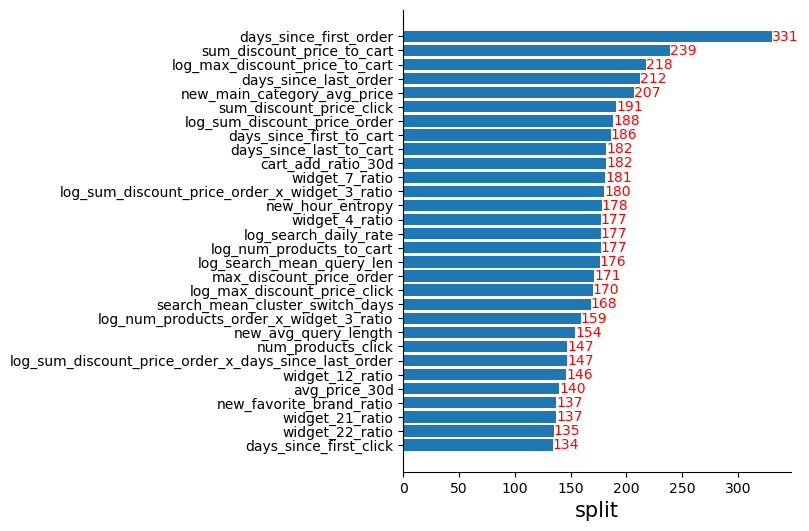

In [127]:
from local_utils import *

print('feature_importance:', lgb_model.feature_importances_, '\n')

plot_lgbm_importance(lgb_model, cols, importance_type='split', top_k=30, sklearn_style=True)

In [128]:
#plot_scores(lgb_model, lgb_tr[cols], lgb_tr.target, lgb_val[cols], lgb_val.target, support_col='days_since_last_order', support_log=False)

Всего ошибочных предсказаний: 440453
Доля ошибок: 23.49%
Неверно предсказали 1 (FP): 102127 (23.19%)
Неверно предсказали 0 (FN): 338326 (76.81%)


c:\Users\Admin\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning:

invalid value encountered in divide

c:\Users\Admin\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning:

invalid value encountered in divide

c:\Users\Admin\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2742: RuntimeWarning:

invalid value encountered in subtract



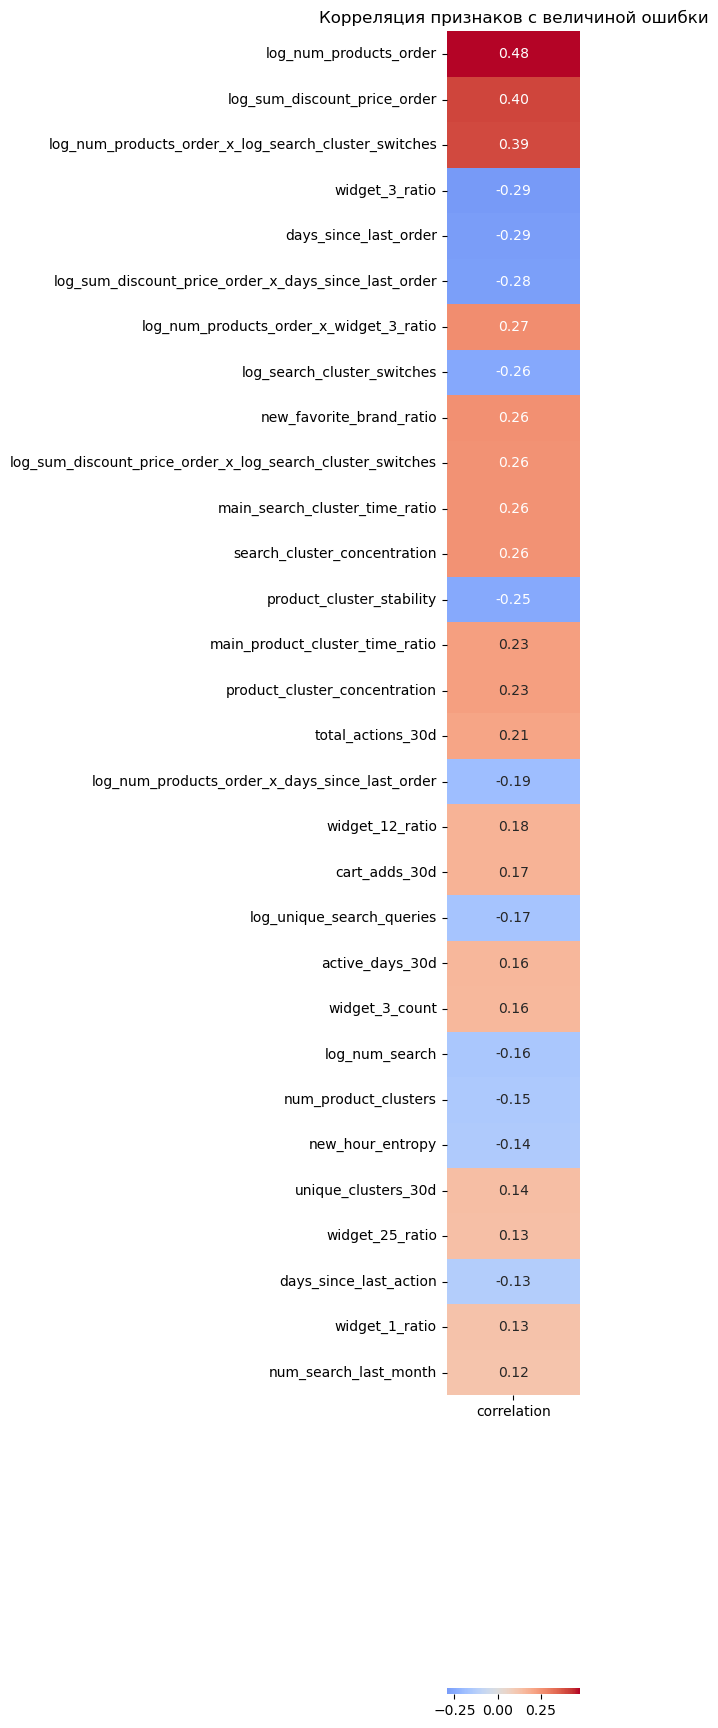

In [129]:
test_predictions: np.ndarray = lgb_model.predict_proba(df_pd[cols])[:, 1]

# Создаем датафрейм с ошибочными предсказаниями
wrong_predictions: pd.DataFrame = df_pd.assign(
    predicted_prob=test_predictions,
    predicted_class=(test_predictions > 0.5).astype(int)
).query(
    "(predicted_class == 1 and target == 0) or (predicted_class == 0 and target == 1)"
).copy()

# Вычисляем величину ошибки (разница между предсказанием и таргетом)
wrong_predictions['error_magnitude']: pd.Series = np.abs(
    wrong_predictions['predicted_prob'] - wrong_predictions['target']
)

# Общая статистика по предсказаниям
print(f"Всего ошибочных предсказаний: {len(wrong_predictions)}")
print(f"Доля ошибок: {len(wrong_predictions)/len(df_pd):.2%}")

# Ложно положительные и ложно отрицательные предсказания. 
fp: pd.DataFrame = wrong_predictions[wrong_predictions['target'] == 0]
fn: pd.DataFrame = wrong_predictions[wrong_predictions['target'] == 1]

print(f"Неверно предсказали 1 (FP): {len(fp)} ({len(fp)/len(wrong_predictions):.2%})")
print(f"Неверно предсказали 0 (FN): {len(fn)} ({len(fn)/len(wrong_predictions):.2%})")

# Вычисляем корреляцию признаков с велечиной ошибки. 
corr_data: pd.DataFrame = wrong_predictions[cols].corrwith(
    wrong_predictions['error_magnitude']
).to_frame('correlation')

# Сортируем и выводим n
corr_data_sorted: pd.DataFrame = corr_data.sort_values(
    'correlation', 
    key=abs, 
    ascending=False
).head(30)

# Строим хитмэп
plt.figure(figsize=(6, 20))
sns.heatmap(
    corr_data_sorted,
    annot=True,
    cmap='coolwarm',
    center=0,
    fmt='.2f',
    cbar_kws={'orientation': 'horizontal'}
)
plt.title('Корреляция признаков с величиной ошибки')
plt.tight_layout()
plt.show()



C:\Users\Admin\AppData\Local\Temp\ipykernel_141116\3761433305.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




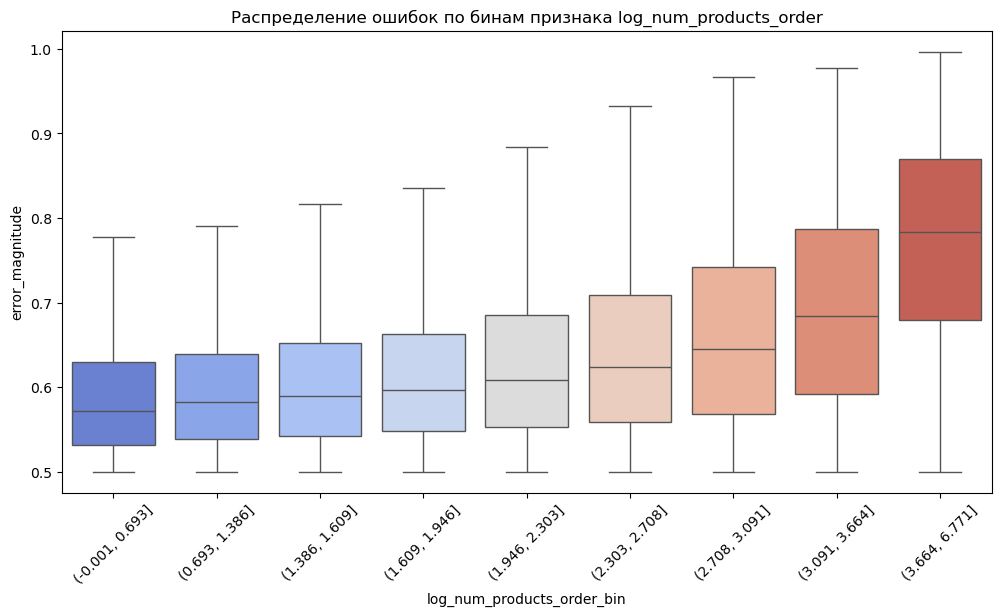

In [140]:
top_feature = corr_data_sorted.index[0]

# Создаем бины (например, 10 квантилей)
wrong_predictions[f'{top_feature}_bin'] = pd.qcut(
    wrong_predictions[top_feature], 
    q=10,  # можно увеличить или уменьшить количество бинов
    duplicates='drop'  # на случай, если есть дублирующиеся границы
)

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=wrong_predictions,
    x=f'{top_feature}_bin',
    y='error_magnitude',
    showfliers=False,
    palette='coolwarm'
)
plt.title(f'Распределение ошибок по бинам признака {top_feature}')
plt.xticks(rotation=45)
plt.show()

In [131]:
#plot_scores(lgb_model, lgb_tr[cols], lgb_tr.target, lgb_val[cols], lgb_val.target, support_col='log_num_products_order_x_days_since_last_order', support_log=False)

In [132]:
feature_1 = 'log_num_products_order' #++
feature_2 = 'days_since_last_order' #--
feature_3 = 'log_sum_discount_price_order' #+

df_pd[f'{feature_1}_x_{feature_2}'] = df_pd[feature_1] * df_pd[feature_2]
df_pd[f'{feature_1}_x_{feature_3}'] = df_pd[feature_1] * df_pd[feature_3]
df_pd[f'{feature_2}_x_{feature_3}'] = df_pd[feature_2] * df_pd[feature_3]


Training low segment model...
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Number of positive: 121358, number of negative: 90726
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21679
[LightGBM] [Info] Number of data points in the train set: 212084, number of used features: 121
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.572217 -> initscore=0.290901
[LightGBM] [Info] Start training from score 0.290901
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
[LightGBM] 

c:\Users\Admin\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning:

invalid value encountered in divide

c:\Users\Admin\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning:

invalid value encountered in divide

c:\Users\Admin\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2742: RuntimeWarning:

invalid value encountered in subtract



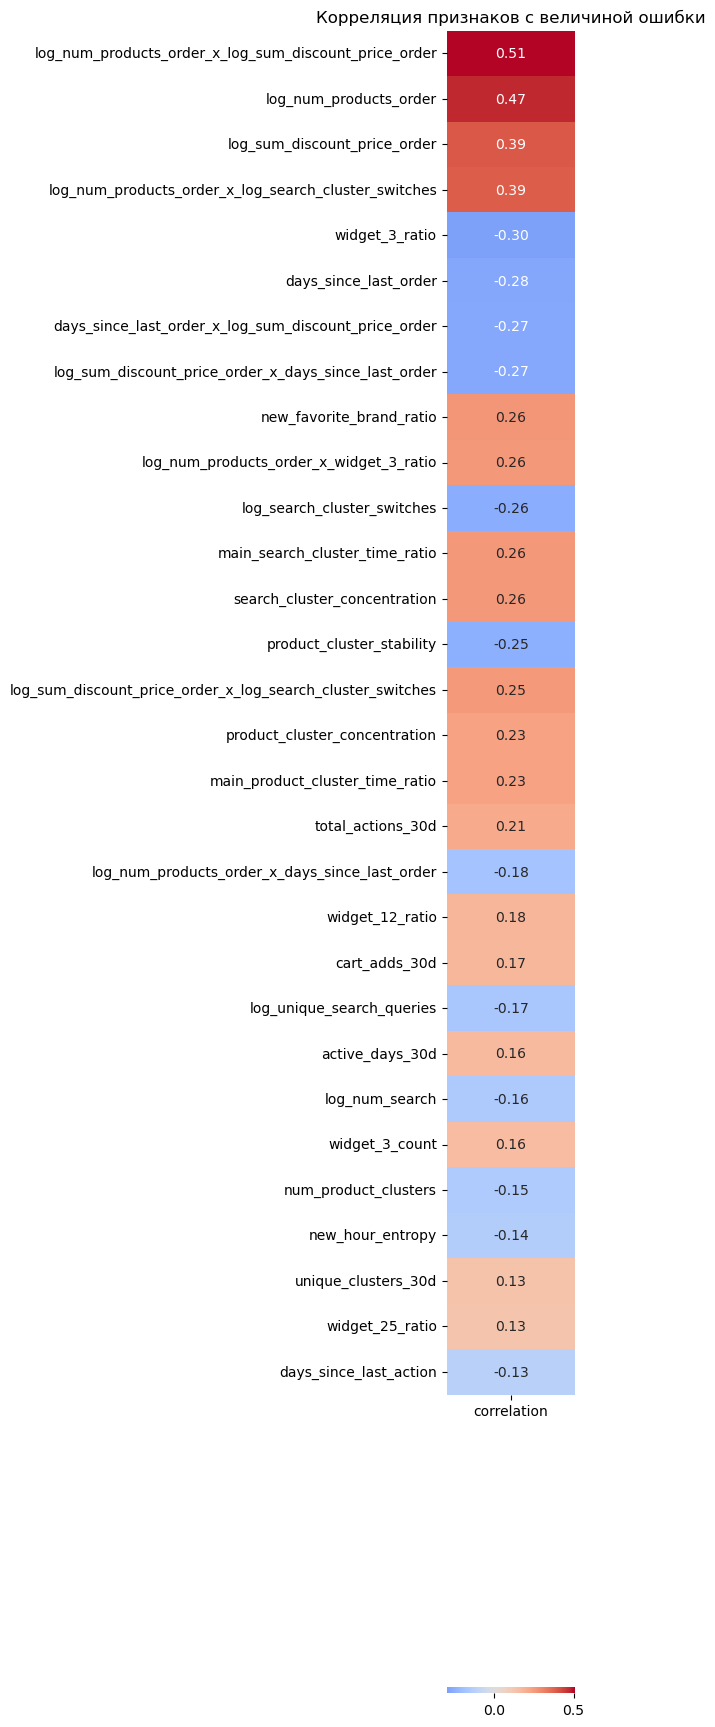


Распределение ошибок по сегментам:
segment
high    0.745756
low     0.254244
Name: proportion, dtype: float64

Средняя величина ошибки по сегментам:
segment
high    0.747096
low     0.612287
Name: error_magnitude, dtype: float64


In [141]:
from local_utils import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Загрузка и подготовка данных
df_pd = df_pd[df_pd['user_id'] != 2346229]
lgb_tr, lgb_val = get_split(df_pd, val_size=0.35)

cols = list(set(df_pd.columns) - {'user_id', 'target', 'last_click_time', 'first_click_time', 
                                 'last_favorite_time', 'first_favorite_time', 
                                 'last_order_time', 'first_order_time', 
                                 'last_to_cart_time', 'first_to_cart_time', 
                                 'last_search_time', 'first_search_time',
                                 'top3_search_clusters', 'top3_search_counts', 
                                 'search_cluster_entropy', 'top3_product_counts', 
                                 'product_cluster_entropy', 'top3_product_clusters'})

# Параметры модели
lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.09,
    'boosting_type': 'gbdt',
    'max_depth': 7,
    'num_iterations': 500,
    'early_stopping_rounds': 100,
    'verbose': 1,
    'importance_type': 'split'
}

# Порог для сегментации
THRESHOLD = 3.0

# 1. Разделяем данные на сегменты
def split_by_segment(df, threshold):
    mask_low = df['log_num_products_order'] <= threshold
    return {
        'low': df[mask_low].copy(),
        'high': df[~mask_low].copy()
    }

# Сегментируем трейн и валидацию
seg_tr = split_by_segment(lgb_tr, THRESHOLD)
seg_val = split_by_segment(lgb_val, THRESHOLD)

# 2. Обучаем отдельные модели для каждого сегмента
models = {}
for segment in ['low', 'high']:
    print(f"\nTraining {segment} segment model...")
    models[segment] = train_model_new(
        seg_tr[segment], 
        seg_val[segment], 
        cols, 
        'target', 
        params=lgb_params, 
        shadow_features=False, 
        sklearn_style=True
    )

# 3. Делаем предсказания на всех данных
def predict_segmented(df, models, threshold):
    mask_low = df['log_num_products_order'] <= threshold
    preds = np.zeros(len(df))
    
    preds[mask_low] = models['low'].predict_proba(df[mask_low][cols])[:, 1]
    preds[~mask_low] = models['high'].predict_proba(df[~mask_low][cols])[:, 1]
    
    return preds

# Предсказания на всем датасете
test_predictions = predict_segmented(df_pd, models, THRESHOLD)

# 4. Анализ ошибок (сохраняем ваш оригинальный код)
wrong_predictions = df_pd.assign(
    predicted_prob=test_predictions,
    predicted_class=(test_predictions > 0.5).astype(int)
).query(
    "(predicted_class == 1 and target == 0) or (predicted_class == 0 and target == 1)"
).copy()

wrong_predictions['error_magnitude'] = np.abs(
    wrong_predictions['predicted_prob'] - wrong_predictions['target']
)

# Статистика ошибок
print(f"\nВсего ошибочных предсказаний: {len(wrong_predictions)}")
print(f"Доля ошибок: {len(wrong_predictions)/len(df_pd):.2%}")

fp = wrong_predictions[wrong_predictions['target'] == 0]
fn = wrong_predictions[wrong_predictions['target'] == 1]

print(f"Неверно предсказали 1 (FP): {len(fp)} ({len(fp)/len(wrong_predictions):.2%})")
print(f"Неверно предсказали 0 (FN): {len(fn)} ({len(fn)/len(wrong_predictions):.2%})")

# Анализ корреляций с ошибками
corr_data = wrong_predictions[cols].corrwith(
    wrong_predictions['error_magnitude']
).to_frame('correlation')

corr_data_sorted = corr_data.sort_values(
    'correlation', 
    key=abs, 
    ascending=False
).head(30)

# Визуализация
plt.figure(figsize=(6, 20))
sns.heatmap(
    corr_data_sorted,
    annot=True,
    cmap='coolwarm',
    center=0,
    fmt='.2f',
    cbar_kws={'orientation': 'horizontal'}
)
plt.title('Корреляция признаков с величиной ошибки')
plt.tight_layout()
plt.show()

# Дополнительный анализ: сравнение ошибок по сегментам
wrong_predictions['segment'] = np.where(
    wrong_predictions['log_num_products_order'] <= THRESHOLD, 
    'low', 
    'high'
)

print("\nРаспределение ошибок по сегментам:")
print(wrong_predictions['segment'].value_counts(normalize=True))

print("\nСредняя величина ошибки по сегментам:")
print(wrong_predictions.groupby('segment')['error_magnitude'].mean())

In [133]:
# Получаем предсказания модели
test_predictions = lgb_model.predict_proba(df_pd[cols])[:, 1]

# Создаем датафрейм с ошибками (ваш код)
wrong_predictions = df_pd.assign(
    predicted_prob=test_predictions,
    predicted_class=(test_predictions > 0.5).astype(int)
).query(
    "(predicted_class == 1 and target == 0) or (predicted_class == 0 and target == 1)"
).copy()

# Вычисляем величину ошибки
wrong_predictions['error_magnitude'] = np.abs(
    wrong_predictions['predicted_prob'] - wrong_predictions['target']
)

# Добавляем флаги типов ошибок
wrong_predictions['error_type'] = np.where(
    (wrong_predictions['predicted_class'] == 1) & (wrong_predictions['target'] == 0),
    'FP',  # False Positive
    'FN'   # False Negative
)

# Выделяем критическую зону (log_num_products_order > 3.5)
critical_zone = wrong_predictions[wrong_predictions['log_num_products_order'] > 3.5].copy()

In [134]:
# Группируем по типу ошибки и выводим медианы ключевых признаков
error_stats = critical_zone.groupby('error_type')[cols].median()
print(error_stats[['log_num_products_order', 'days_since_last_order']])

            log_num_products_order  days_since_last_order
error_type                                               
FN                        3.713572                   64.0
FP                        4.007333                   13.0


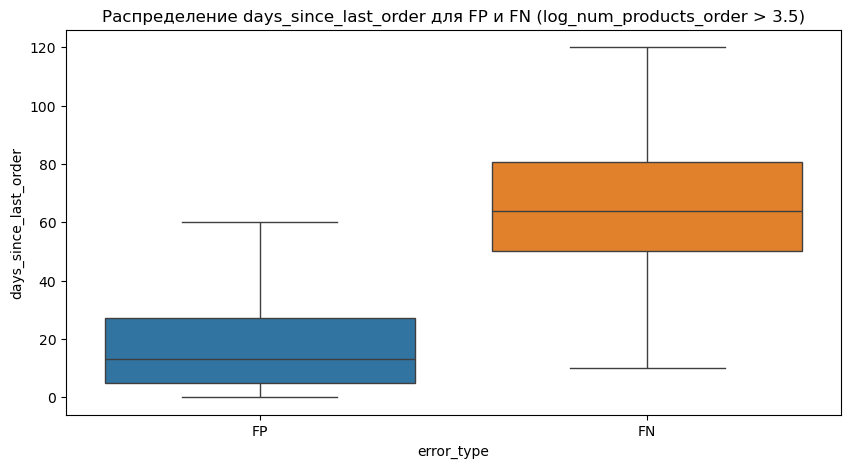

In [135]:
import seaborn as sns
import matplotlib.pyplot as plt

# Пример для days_since_last_order
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=critical_zone,
    x='error_type',
    y='days_since_last_order',
    hue='error_type',
    showfliers=False
)
plt.title('Распределение days_since_last_order для FP и FN (log_num_products_order > 3.5)')
plt.show()

In [136]:
# Случайные примеры FP (модель: 1, истина: 0)
fp_samples = critical_zone[critical_zone['error_type'] == 'FP'].sample(3, random_state=42)
print("Примеры False Positive (FP):")
display(fp_samples[['log_num_products_order', 'predicted_prob', 'target'] + cols[:20]])

# Случайные примеры FN (модель: 0, истина: 1)
fn_samples = critical_zone[critical_zone['error_type'] == 'FN'].sample(3, random_state=42)
print("\nПримеры False Negative (FN):")
display(fn_samples[['log_num_products_order', 'predicted_prob', 'target'] + cols[:20]])

Примеры False Positive (FP):


,log_num_products_order,predicted_prob,target,search_mean_cluster_switch_days,widget_10_ratio,widget_3_count,days_since_last_action,widget_3_ratio,widget_14_ratio,days_since_last_order,...,num_search_clusters,widget_17_ratio,product_cluster_stability,widget_12_count,new_morning_activity_ratio,widget_8_count,main_cluster_ratio_30d,main_product_cluster_time_ratio,widget_14_count,widget_19_count
400494,4.143135,0.606681,0,-0.320000,0.002681,63.0,16.0,0.168901,0.0,33.0,...,16.0,0.0,0.946381,26.0,0.096515,6.0,0.600000,0.335121,0.0,0.0
1248312,4.219508,0.613257,0,0.047619,0.003226,68.0,1.0,0.109677,0.0,45.0,...,16.0,0.0,0.967742,90.0,0.293548,1.0,0.322581,0.298387,0.0,0.0
1874823,4.969813,0.865160,0,-0.779310,0.000000,144.0,4.0,0.375979,0.0,10.0,...,17.0,0.0,0.953003,6.0,0.023499,0.0,0.406250,0.154047,0.0,0.0



Примеры False Negative (FN):


,log_num_products_order,predicted_prob,target,search_mean_cluster_switch_days,widget_10_ratio,widget_3_count,days_since_last_action,widget_3_ratio,widget_14_ratio,days_since_last_order,...,num_search_clusters,widget_17_ratio,product_cluster_stability,widget_12_count,new_morning_activity_ratio,widget_8_count,main_cluster_ratio_30d,main_product_cluster_time_ratio,widget_14_count,widget_19_count
1788237,3.871201,0.478449,1,0.000000,0.003077,48.0,4.0,0.147692,0.0,30.0,...,3.0,0.0,0.950769,8.0,0.806154,41.0,0.224138,0.209231,0.0,0.0
1747229,3.637586,0.470217,1,1.577778,0.000000,38.0,28.0,0.275362,0.0,97.0,...,16.0,0.0,0.884058,0.0,0.579710,1.0,0.205882,0.159420,0.0,0.0
751533,3.806663,0.483753,1,-0.031250,0.007782,45.0,6.0,0.175097,0.0,83.0,...,11.0,0.0,0.933852,18.0,0.151751,3.0,0.222222,0.241245,0.0,0.0


In [137]:
import umap
import plotly.express as px
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 1. Подготовка данных - выбираем 20 случайных признаков из списка cols
import random
cluster_cols = random.sample(cols, 5)  # Используем random.sample для списка
cluster_data = critical_zone[cluster_cols].fillna(0)

# Берем подвыборку для быстрой визуализации (можно убрать для полного анализа)
sampled_indices = cluster_data.sample(10000, random_state=42).index
sampled_data = cluster_data.loc[sampled_indices]

# 2. Масштабирование и UMAP
scaler = StandardScaler()
scaled_data = scaler.fit_transform(sampled_data)

reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = reducer.fit_transform(scaled_data)

# 3. Кластеризация
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(umap_result)

# 4. Подготовка данных для визуализации
plot_data = critical_zone.loc[sampled_indices].copy()
plot_data['umap_x'] = umap_result[:, 0]
plot_data['umap_y'] = umap_result[:, 1]
plot_data['cluster'] = clusters.astype(str)  # Для категориального отображения

# 5. Интерактивная визуализация
fig = px.scatter(
    plot_data,
    x='umap_x',
    y='umap_y',
    color='error_type',
    symbol='cluster',
    hover_data=cluster_cols,
    title='Интерактивная визуализация ошибок FP/FN по кластерам',
    width=1000,
    height=600,
    color_discrete_map={'FP': '#FF7F0E', 'FN': '#1F77B4'}  # Оранжевый/синий
)

# Улучшаем легенду и подписи
fig.update_layout(
    legend_title_text='Тип ошибки / Кластер',
    xaxis_title='UMAP Dimension 1',
    yaxis_title='UMAP Dimension 2',
    hovermode='closest'
)

# Генерируем динамический hovertemplate с выбранными признаками
hover_template = "<b>%{hovertext}</b><br><br>" + \
                "UMAP 1: %{x}<br>UMAP 2: %{y}<br>" + \
                "<br>".join([f"{col}: %{{customdata[{i}]:.2f}}" 
                           for i, col in enumerate(cluster_cols)])

fig.update_traces(hovertemplate=hover_template)

fig.show()

# 6. Анализ кластеров (вывод в табличном виде)
print("\nСтатистика по кластерам:")
cluster_stats = plot_data.groupby(['cluster', 'error_type'])[cluster_cols].mean()
display(cluster_stats)

print("\nРаспределение ошибок:")
error_dist = pd.crosstab(plot_data['cluster'], plot_data['error_type'], normalize='index')
display(error_dist.style.format('{:.1%}'))

c:\Users\Admin\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.




Статистика по кластерам:


log_num_products_order_x_widget_3_ratio  \
cluster error_type                                            
0       FN                                         0.971874   
        FP                                         1.452151   
1       FN                                         0.756526   
        FP                                         0.852323   

                    favorite_ratio_30d  widget_10_ratio  widget_18_count  \
cluster error_type                                                         
0       FN                    0.002605         0.003746         0.032258   
        FP                    0.003636         0.002226         0.009314   
1       FN                    0.069663         0.000182         0.009091   
        FP                    0.019052         0.000212         0.013013   

                    days_since_last_action  
cluster error_type                          
0       FN                       17.465909  
        FP                       10.718953  
1       FN                        7.700855  
        FP                        5.076820


Распределение ошибок:


error_type,FN,FP
cluster,,
0,2.2%,97.8%
1,5.1%,94.9%


In [138]:
ы

NameError: name 'ы' is not defined

------------------------------------------------------

------------------------------------------------------

------------------------------------------------------

In [ ]:
actions_history = pl.scan_parquet(os.path.join(data_path, 'actions_history/*.parquet')).collect()
search_history = pl.scan_parquet(os.path.join(data_path, 'cluster_search/*.parquet')).collect()
widget_info = pl.read_csv(os.path.join(data_path, 'widget_info.csv'))
product_information = pl.read_csv(
    os.path.join(data_path, 'cluster_product_information.csv'),
    ignore_errors=True
)

actions_aggs = {}
actions_id_to_suf = {
    1: "click",
    2: "favorite", 
    3: "order",
    5: "to_cart",
}

# Сначала соберем все агрегированные данные
all_aggs = []
numeric_features = []

for id_, suf in actions_id_to_suf.items():
    aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= val_end_date)
        .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
        .filter(pl.col('action_type_id') == id_)
        .join(
            product_information.select('product_id', 'discount_price'),
            on='product_id',
        )
        .group_by('user_id')
        .agg(
            pl.count('product_id').cast(pl.Int32).alias(f'num_products_{suf}'),
            pl.sum('discount_price').cast(pl.Float32).alias(f'sum_discount_price_{suf}'),
            pl.max('discount_price').cast(pl.Float32).alias(f'max_discount_price_{suf}'),
            pl.max('timestamp').alias(f'last_{suf}_time'),
            pl.min('timestamp').alias(f'first_{suf}_time'),
        )
        .with_columns([
            (pl.lit(test_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),
            
            (pl.lit(test_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
        ])
    )
    
    # Сохраняем имена числовых фичей для создания полиномов
    numeric_features.extend([
        f'num_products_{suf}',
        f'sum_discount_price_{suf}', 
        f'max_discount_price_{suf}',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
    ])
    
    actions_aggs[id_] = aggs
    all_aggs.append(aggs)

# Объединяем все агрегации по user_id с суффиксами
combined_val = all_aggs[0]
for i, agg in enumerate(all_aggs[1:], 1):
    combined_val = combined_val.join(
        agg, 
        on='user_id', 
        how='outer',
        suffix=f"_{i}"
    )

C:\Users\Admin\AppData\Local\Temp\ipykernel_118412\2116779191.py:67: DeprecationWarning: Use of `how='outer'` should be replaced with `how='full'`.
  combined_val = combined_val.join(


In [ ]:
id_ = 4
suf = 'search'

# Вычисляем top3 кластеров для валидации (аналогично трейну)
val_cluster_counts = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        pl.col('cluster').value_counts().alias('cluster_counts')
    )
    .explode('cluster_counts')
    .with_columns(
        pl.col('cluster_counts').struct.field('cluster').alias('cluster_name'),
        pl.col('cluster_counts').struct.field('count').alias('cluster_count')
    )
    .group_by('user_id')
    .agg(
        pl.col('cluster_name').sort_by('cluster_count', descending=True).head(3).alias('top3_clusters'),
        pl.col('cluster_count').sort(descending=True).head(3).alias('top3_counts')
    )
)

actions_aggs[id_] = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        # Общее количество поисков за 5 месяцев
        pl.count('search_query').cast(pl.Int32).alias(f'num_{suf}'),
        pl.col('search_query').n_unique().alias(f'unique_{suf}_queries'),
        
        # Количество поисков за последний месяц (30 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_month'),
        
        # Количество поисков за последнюю неделю (7 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=7))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_week'),

        (pl.count() / (pl.max('timestamp') - pl.min('timestamp')).dt.total_days()).alias(f'{suf}_daily_rate'),

        pl.col('cluster').n_unique().alias(f'num_{suf}_clusters'),
        pl.col('cluster').mode().first().alias(f'main_{suf}_cluster'),
        
        # Динамика кластеров
        pl.col('cluster')
            .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30))
            .mode().first()
            .alias(f'recent_{suf}_cluster'),

        (pl.col('cluster').value_counts().struct.field('count').max() / pl.col('cluster').count()).alias(f'{suf}_cluster_concentration'),
        
        # Энтропия кластеров
        (-(pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count()).log()
            * (pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count())
            .sum()).alias(f'{suf}_cluster_entropy'),
        
        # Переключения между кластерами
        pl.col('cluster').diff().fill_null(0).abs().sum().alias(f'{suf}_cluster_switches'),
        
        # Стабильность кластеров
        ((pl.col('cluster').count() - pl.col('cluster').n_unique()) / pl.col('cluster').count())
            .alias(f'{suf}_cluster_stability'),
        
        # Время в основном кластере
        (pl.col('timestamp')
            .filter(pl.col('cluster') == pl.col('cluster').mode().first())
            .count() / pl.col('timestamp').count())
            .alias(f'main_{suf}_cluster_time_ratio'),

        pl.col('timestamp').filter(pl.col('cluster').diff().fill_null(0) != 0)
            .diff()
            .dt.total_days()
            .mean()
            .alias(f'{suf}_mean_cluster_switch_days'),

        pl.col('search_query').str.len_chars().mean().alias(f'{suf}_mean_query_len'),
        
        (pl.col('search_query').str.len_chars()
            .filter(pl.col('cluster') == pl.col('cluster').mode().first()).mean() - 
            pl.col('search_query').str.len_chars()
                .filter(pl.col('cluster') != pl.col('cluster').mode().first()).mean())
                .alias(f'{suf}_main_cluster_query_len_diff'),

        pl.max('timestamp').alias(f'last_{suf}_time'),
        pl.min('timestamp').alias(f'first_{suf}_time'),
    )
    .join(val_cluster_counts, on='user_id', how='left')
    .with_columns([
        (pl.lit(test_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),

        (pl.lit(test_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
    ])
    .select(
        'user_id',
        f'num_{suf}',
        f'unique_{suf}_queries',
        f'num_{suf}_last_month',
        f'num_{suf}_last_week',
        f'{suf}_daily_rate',
        f'num_{suf}_clusters',
        f'main_{suf}_cluster',
        pl.col('top3_clusters').alias(f'top3_{suf}_clusters'),
        pl.col('top3_counts').alias(f'top3_{suf}_counts'),
        f'recent_{suf}_cluster',
        f'{suf}_cluster_concentration',
        f'{suf}_cluster_entropy',
        f'{suf}_cluster_switches',
        f'{suf}_cluster_stability',
        f'main_{suf}_cluster_time_ratio',
        f'{suf}_mean_cluster_switch_days',
        f'{suf}_mean_query_len',
        f'{suf}_main_cluster_query_len_diff',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
        f'last_{suf}_time',
        f'first_{suf}_time',
    )
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_118412\555555092.py:51: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.count() / (pl.max('timestamp') - pl.min('timestamp')).dt.total_days()).alias(f'{suf}_daily_rate'),


In [ ]:
val_product_cluster_aggs = (
    actions_history
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
    .join(
        product_information.select('product_id', 'cluster'),
        on='product_id'
    )
    .group_by('user_id')
    .agg(
        # Общие агрегаты по кластерам продуктов
        pl.col('cluster').n_unique().alias('num_product_clusters'),
        pl.col('cluster').mode().first().alias('main_product_cluster'),
        
        # Аналогичные агрегаты как для search
        (pl.col('cluster').value_counts().struct.field('count').max() / pl.col('cluster').count()).alias('product_cluster_concentration'),
        
        # Энтропия кластеров продуктов
        (-(pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count()).log()
            * (pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count())
            .sum()).alias('product_cluster_entropy'),
        
        # Стабильность кластеров продуктов
        ((pl.col('cluster').count() - pl.col('cluster').n_unique()) / pl.col('cluster').count())
            .alias('product_cluster_stability'),
        
        # Время в основном кластере продуктов
        (pl.col('timestamp')
            .filter(pl.col('cluster') == pl.col('cluster').mode().first())
            .count() / pl.col('timestamp').count()
        ).alias('main_product_cluster_time_ratio'),
            
        # Top 3 кластеров продуктов
        pl.col('cluster').value_counts().struct.field('cluster').alias('top_product_clusters'),
        pl.col('cluster').value_counts().struct.field('count').alias('top_product_counts')
    )
    .with_columns(
        pl.col('top_product_clusters').list.head(3).alias('top3_product_clusters'),
        pl.col('top_product_counts').list.head(3).alias('top3_product_counts')
    )
    .drop(['top_product_clusters', 'top_product_counts'])
)

In [ ]:
test_last_month_features = (
    actions_history
    .filter(
        (pl.col('timestamp').dt.date() < test_start_date) &  # до теста
        (pl.col('timestamp').dt.date() >= test_start_date - timedelta(days=30))  # последние 30 дней
    )
    .join(
        product_information.select('product_id', 'discount_price', 'cluster'),
        on='product_id'
    )
    .group_by('user_id')
    .agg(
        # Те же метрики, что и для трейна
        pl.count().alias('total_actions_30d'),
        (pl.col('action_type_id') == 1).sum().alias('clicks_30d'),
        (pl.col('action_type_id') == 2).sum().alias('favorites_30d'),
        (pl.col('action_type_id') == 5).sum().alias('cart_adds_30d'),
        
        pl.sum('discount_price').alias('total_spent_30d'),
        pl.mean('discount_price').alias('avg_price_30d'),
        
        (test_start_date - pl.col('timestamp').max().dt.date()).dt.total_days().alias('days_since_last_action'),
        (pl.col('timestamp').max() - pl.col('timestamp').min()).dt.total_days().alias('active_days_30d'),
        
        pl.col('cluster').n_unique().alias('unique_clusters_30d'),
        (pl.col('cluster').value_counts().struct.field('count').max() / pl.count()).alias('main_cluster_ratio_30d')
    )
    .with_columns(
        (pl.col('total_actions_30d') / pl.col('active_days_30d')).alias('daily_actions_rate_30d'),
        (pl.col('cart_adds_30d') / pl.col('total_actions_30d')).alias('cart_add_ratio_30d'),
        (pl.col('favorites_30d') / pl.col('total_actions_30d')).alias('favorite_ratio_30d')
    )
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_118412\4126633476.py:14: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias('total_actions_30d'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_118412\4126633476.py:26: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.col('cluster').value_counts().struct.field('count').max() / pl.count()).alias('main_cluster_ratio_30d')


In [ ]:
# Сначала получим список реально существующих виджетов
existing_widgets = (
    actions_history
    .filter(pl.col('widget_name_id').is_not_null())
    .select(pl.col('widget_name_id').unique())
    .to_series()
    .to_list()
)

# Теперь создаем агрегаты только для существующих виджетов
widget_aggs = (
    actions_history
    .filter(
        (pl.col('timestamp').dt.date() <= val_end_date) &
        (pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5)) &
        (pl.col('widget_name_id').is_not_null())
    )
    .group_by(['user_id', 'widget_name_id'])
    .agg(
        pl.count().alias('widget_count')
    )
    .join(
        actions_history
        .filter(
        (pl.col('timestamp').dt.date() <= val_end_date) &
        (pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5)) &
            (pl.col('widget_name_id').is_not_null())
        )
        .group_by('user_id')
        .agg(pl.count().alias('total_widget_actions')),
        on='user_id'
    )
    .with_columns(
        (pl.col('widget_count') / pl.col('total_widget_actions')).alias('widget_ratio')
    )
    .group_by('user_id')
    .agg([
        *[pl.col('widget_count').filter(pl.col('widget_name_id') == widget_id).first().alias(f'widget_{widget_id}_count') 
          for widget_id in existing_widgets],
        *[pl.col('widget_ratio').filter(pl.col('widget_name_id') == widget_id).first().alias(f'widget_{widget_id}_ratio') 
          for widget_id in existing_widgets]
    ])
    .fill_null(0)
)

if 'total_widget_actions' in widget_aggs.columns:
    widget_aggs = widget_aggs.drop('total_widget_actions')

C:\Users\Admin\AppData\Local\Temp\ipykernel_118412\2057899543.py:20: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias('widget_count')
C:\Users\Admin\AppData\Local\Temp\ipykernel_118412\2057899543.py:30: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias('total_widget_actions')),


In [ ]:
from local_utils import *

test_users_submission = (
    pl.read_csv(os.path.join(data_path, 'test_users.csv'))
)

test_df_main = test_users_submission
for _, actions_aggs_df in actions_aggs.items():
    test_df_main = (
        test_df_main
        .join(actions_aggs_df, on='user_id', how='left')
    )
test_df_main = test_df_main.join(val_product_cluster_aggs, on='user_id', how='left')
test_df_main = test_df_main.join(test_last_month_features, on='user_id', how='left')
test_df_main = test_df_main.join(widget_aggs, on='user_id', how='left')


test_df_pd = test_df_main.to_pandas()

test_df_pd = apply_log_transform(test_df_pd, columns_to_log, drop_original=True)

In [ ]:
test_df_pd = advansed_knn_features_faiss(test_df_pd, knn_cols, n_neighbors=6, use_gpu=True)

Nans filled
Data scaled
Using CPU
FAISS index built
KNN search done


c:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
c:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\_methods.py:152: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


KNN features created


In [ ]:
# Загрузите данные заново (если нужно)
actions_history = pl.scan_parquet(os.path.join(data_path, 'actions_history/*.parquet'))
search_history = pl.scan_parquet(os.path.join(data_path, 'cluster_search/*.parquet'))
product_info = product_information


test_df_pd = add_time_pattern_features(test_df_pd, actions_history, product_info)
test_df_pd = add_brand_category_features(test_df_pd, actions_history, product_info) 
test_df_pd = add_search_features(test_df_pd, search_history)

C:\Users\Admin\AppData\Local\Temp\ipykernel_118412\703708266.py:22: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.sum('new_is_morning') / pl.count()).alias('new_morning_activity_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_118412\703708266.py:23: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.sum('new_is_day') / pl.count()).alias('new_day_activity_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_118412\703708266.py:24: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.sum('new_is_weekend') / pl.count()).alias('new_weekend_activity_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_118412\600433880.py:15: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.col('brand').value_counts().struct.field('count').max() / pl.count()).alias('new_favorite_brand_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_118412\2438321060.py:12: Dep

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from local_utils import *

df_pd = df_pd[df_pd['user_id'] != 2346229]
lgb_tr, lgb_val = get_split(df_pd, val_size=0.37)

cols = list(set(df_pd.columns) - {'user_id', 'target', 'last_click_time', 'first_click_time', 
                                 'last_favorite_time', 'first_favorite_time', 
                                 'last_order_time', 'first_order_time', 
                                 'last_to_cart_time', 'first_to_cart_time', 
                                 'last_search_time', 'first_search_time',
                                 'top3_search_clusters', 'top3_search_counts', 
                                 'search_cluster_entropy', 'top3_product_counts', 
                                 'product_cluster_entropy', 'top3_product_clusters'})

lgb_params={
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.07,
    'boosting_type': 'gbdt',

    'max_depth': 10,

    'num_iterations': 500,
    'early_stopping_rounds': 100,
    'verbose': 1,
    'importance_type': 'split'
}

n_models = 10
feature_frac = 0.85

feature_subsets = []
remaining_features = set(cols.copy())

for i in range(n_models):
    if remaining_features:
        # Берем часть еще неиспользованных фичей
        n_new_features = max(1, int(len(remaining_features) / (n_models - i)))
        new_features = np.random.choice(list(remaining_features), n_new_features, replace=False)
        remaining_features -= set(new_features)
        
        # Добираем случайными фичами до 70%
        n_additional = int(len(cols) * feature_frac) - len(new_features)
        additional_features = np.random.choice(
            [f for f in cols if f not in new_features], 
            n_additional, 
            replace=False
        )
        
        feature_subset = list(new_features) + list(additional_features)
    else:
        # Все фичи уже использованы, просто берем случайные 70%
        feature_subset = np.random.choice(cols, int(len(cols) * feature_frac), replace=False)
    
    feature_subsets.append(feature_subset)

# Обучаем базовые модели и собираем их предсказания
base_models = []
train_predictions = np.zeros((len(lgb_tr), n_models))
val_predictions = np.zeros((len(lgb_val), n_models))

for i, feature_subset in enumerate(feature_subsets):
    print(f"Training base model {i+1} on {len(feature_subset)} features...")
    
    # Обучаем модель на подвыборке фичей
    model = train_model_new(
        lgb_tr, 
        lgb_val, 
        feature_subset, 
        'target', 
        params=lgb_params, 
        shadow_features=False, 
        sklearn_style=True
    )
    base_models.append(model)
    
    # Получаем предсказания на трейне и валидации
    train_predictions[:, i] = model.predict_proba(lgb_tr[feature_subset])[:, 1]
    val_predictions[:, i] = model.predict_proba(lgb_val[feature_subset])[:, 1]

Training base model 1 on 153 features...
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Number of positive: 407614, number of negative: 773607
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.120166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30654
[LightGBM] [Info] Number of data points in the train set: 1181221, number of used features: 153
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.345079 -> initscore=-0.640743
[LightGBM] [Info] Start training from score -0.640743
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 roun

In [ ]:
res = []
for i, m in enumerate(base_models):
    feature_subset = feature_subsets[i]
    res.append(m.predict_proba(test_df_pd[feature_subset])[:, 1])

In [ ]:
# 1. Создаем DataFrame с предсказаниями (как в предыдущих шагах)
predictions_array = np.array(res).T
res_df = pd.DataFrame(predictions_array, columns=[f'Model_{i+1}' for i in range(len(res))])

# 2. Добавляем user_id из исходных данных
res_df['user_id'] = test_df_pd['user_id'].values  # или reset_index(), если нужно

# 3. Добавляем усредненное предсказание (если нужно)
res_df['predict'] = res_df[[f'Model_{i+1}' for i in range(len(res))]].mean(axis=1)

# 4. Сохраняем только нужные колонки
res_df

,Model_1,Model_2,Model_3,Model_4,Model_5,Model_6,Model_7,Model_8,Model_9,Model_10,user_id,predict
0,0.163848,0.151501,0.143849,0.159109,0.177990,0.139414,0.151299,0.172207,0.151559,0.160416,1342,0.157119
1,0.781676,0.785460,0.758141,0.762851,0.800278,0.756027,0.758547,0.808855,0.766794,0.785301,9852,0.776393
2,0.358801,0.307780,0.329879,0.348273,0.336373,0.313459,0.331860,0.341773,0.297637,0.368027,10206,0.333386
3,0.369496,0.322500,0.340843,0.361194,0.346016,0.321946,0.348756,0.336216,0.297637,0.385020,11317,0.342962
4,0.693256,0.619441,0.671695,0.679757,0.630591,0.634222,0.693497,0.628666,0.630219,0.667170,13289,0.654851
...,...,...,...,...,...,...,...,...,...,...,...,...
2068419,0.363627,0.306942,0.333448,0.353051,0.326982,0.312487,0.327343,0.331848,0.284826,0.366380,11157283,0.330693
2068420,0.042642,0.051597,0.047130,0.055152,0.047629,0.045368,0.044386,0.045191,0.045968,0.056030,11160395,0.048109
2068421,0.591703,0.556180,0.548969,0.586367,0.577708,0.584674,0.584155,0.617923,0.579643,0.566069,11165052,0.579339
2068422,0.504815,0.493915,0.503179,0.526002,0.486337,0.493736,0.492050,0.510169,0.456274,0.542342,11168218,0.500882


In [ ]:
res_df[['user_id', 'predict']].to_csv('jjjjjjjjjjjjjjjjj.csv', index=False)

In [ ]:
ы

In [ ]:
from local_utils import *

df_pd = df_pd[df_pd['user_id'] != 2346229]

lgb_tr, lgb_val = get_split(df_pd, val_size=0.35)

cols = list(set(df_pd.columns) - {'user_id', 'target', 'last_click_time', 'first_click_time', 'last_favorite_time', 'first_favorite_time', 
                                  'last_order_time', 'first_order_time', 'last_to_cart_time', 'first_to_cart_time', 'last_search_time', 'first_search_time',
                                  'top3_search_clusters', 'top3_search_counts', 'search_cluster_entropy', 'top3_product_counts', 'product_cluster_entropy', 'top3_product_clusters'})

lgb_params={
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.08,
    'boosting_type': 'gbdt',
    'max_depth': 7,
    'num_iterations': 400,
    'early_stopping_rounds': 100,
    'verbose': 1,
    'importance_type': 'split'
}

eee_lgb_model = train_model_new(lgb_tr, lgb_val, cols, 'target', params=lgb_params, shadow_features=False, sklearn_style=True)

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Number of positive: 420882, number of negative: 797838
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.172972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 48505
[LightGBM] [Info] Number of data points in the train set: 1218720, number of used features: 241
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.345348 -> initscore=-0.639553
[LightGBM] [Info] Start training from score -0.639553
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.765223	valid's au

In [ ]:
# Получаем предсказания вероятностей для тестовых данных
test_predictions = eee_lgb_model.predict_proba(df_pd[cols])[:, 1]
test_predictions_rounded = np.round(test_predictions, 2)

shap_df_pd = df_pd.copy()

# Добавляем предсказания в тестовый DataFrame
shap_df_pd['predicted_prob'] = test_predictions
shap_df_pd['predicted_prob_rounded'] = test_predictions_rounded

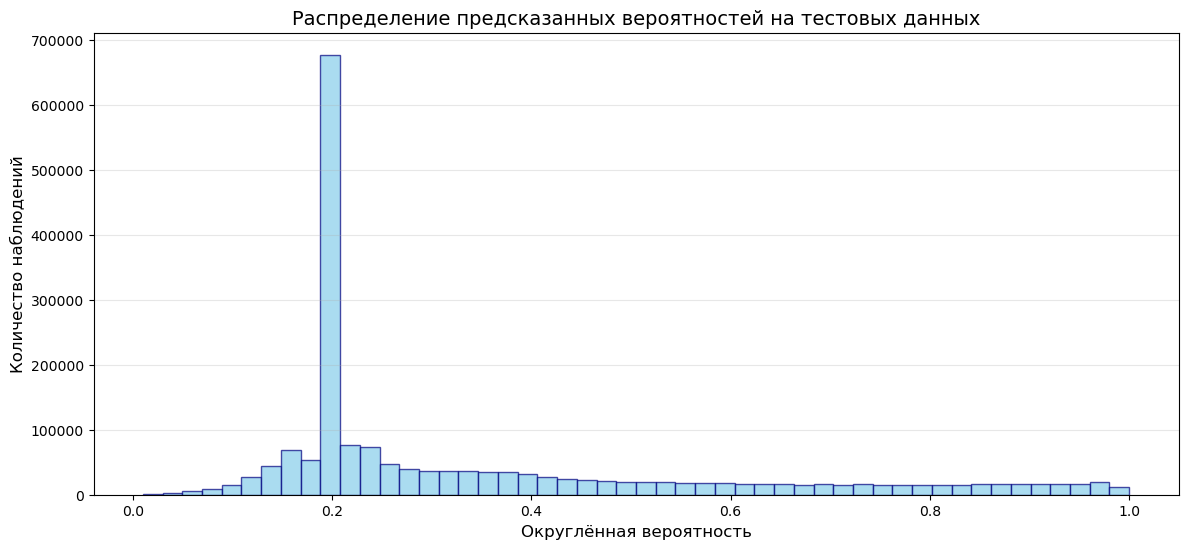

In [ ]:
plt.figure(figsize=(14, 6))
plt.hist(test_predictions_rounded, bins=50, color='skyblue', edgecolor='navy', alpha=0.7)
plt.title('Распределение предсказанных вероятностей на тестовых данных', fontsize=14)
plt.xlabel('Округлённая вероятность', fontsize=12)
plt.ylabel('Количество наблюдений', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.show()

In [ ]:
# Выделяем объекты с неопределёнными предсказаниями (0.15-0.25)
uncertain_samples = shap_df_pd[(test_predictions_rounded >= 0.15) & 
                             (test_predictions_rounded <= 0.25)]

print(f"Количество неопределённых предсказаний: {len(uncertain_samples)}")
print(f"Доля от общего числа: {len(uncertain_samples)/len(shap_df_pd):.2%}")

Количество неопределённых предсказаний: 968941
Доля от общего числа: 51.68%


c:\Users\Admin\anaconda3\Lib\site-packages\shap\explainers\_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
C:\Users\Admin\AppData\Local\Temp\ipykernel_100192\1911305788.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, shap_sample, plot_type="bar", max_display=15)


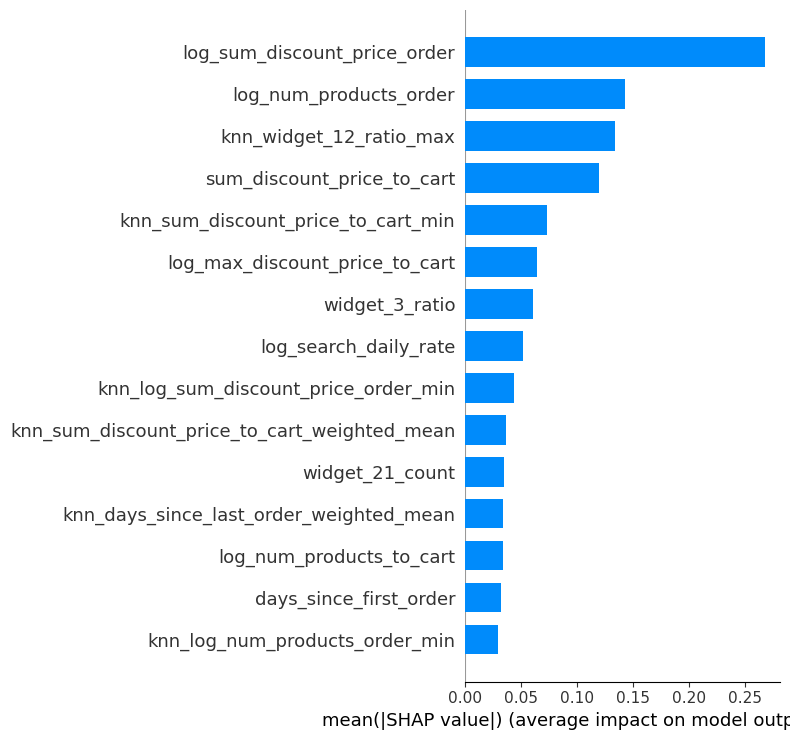

In [ ]:
import shap

# Инициализируем explainer
explainer = shap.TreeExplainer(eee_lgb_model)

# Вычисляем SHAP значения для подвыборки (для экономии времени)
shap_sample = shap_df_pd[cols].sample(min(1000, len(shap_df_pd)), random_state=42)
shap_values = explainer.shap_values(shap_sample)

# Визуализация важности признаков
shap.summary_plot(shap_values, shap_sample, plot_type="bar", max_display=15)

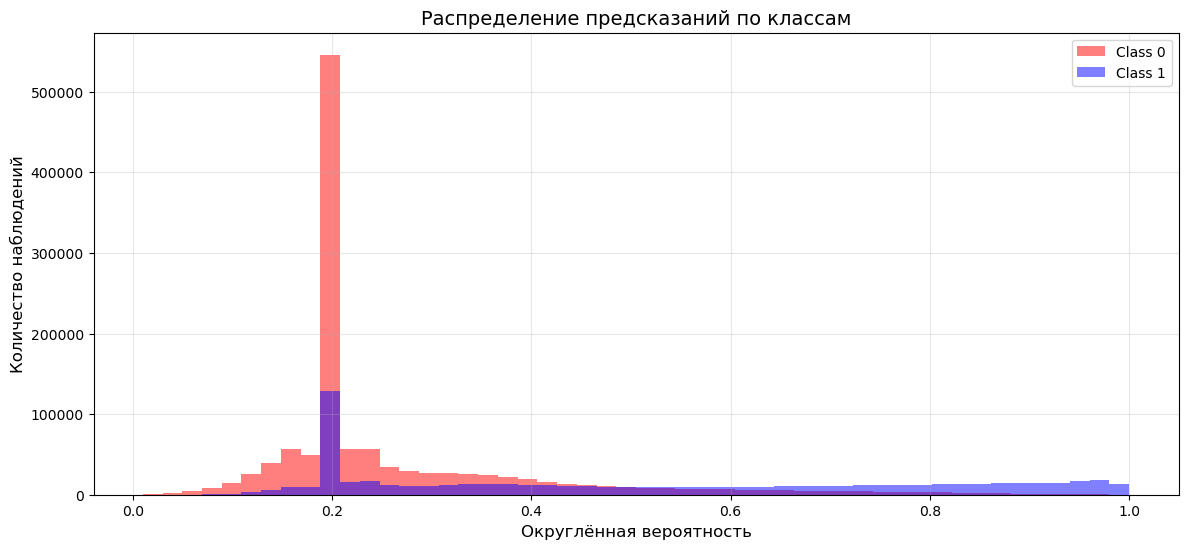

In [ ]:
# Если есть истинные метки (target) в тестовых данных
if 'target' in shap_df_pd.columns:
    plt.figure(figsize=(14, 6))
    
    # Для класса 0
    plt.hist(test_predictions_rounded[shap_df_pd['target'] == 0], 
             bins=50, alpha=0.5, color='red', label='Class 0')
    
    # Для класса 1
    plt.hist(test_predictions_rounded[shap_df_pd['target'] == 1], 
             bins=50, alpha=0.5, color='blue', label='Class 1')
    
    plt.title('Распределение предсказаний по классам', fontsize=14)
    plt.xlabel('Округлённая вероятность', fontsize=12)
    plt.ylabel('Количество наблюдений', fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

In [ ]:
# Примеры с максимальной неопределённостью
uncertain_examples = shap_df_pd.iloc[np.argsort(np.abs(test_predictions - 0.5))[:5]]

# Примеры с явными ошибками (если есть target)
if 'target' in shap_df_pd.columns:
    wrong_predictions = shap_df_pd[
        ((test_predictions > 0.5) & (shap_df_pd['target'] == 0)) | 
        ((test_predictions < 0.5) & (shap_df_pd['target'] == 1))
    ]
    print(f"\nКоличество ошибочных предсказаний: {len(wrong_predictions)}")


Количество ошибочных предсказаний: 440326


In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score

# Сводная статистика
report = {
    "Общее количество наблюдений": len(shap_df_pd),
    "Средняя предсказанная вероятность": test_predictions.mean(),
    "Доля неопределённых предсказаний (0.15-0.25)": len(uncertain_samples)/len(shap_df_pd),
}

if 'target' in shap_df_pd.columns:
    report.update({
        "AUC-ROC": roc_auc_score(shap_df_pd['target'], test_predictions),
        "Accuracy": accuracy_score(shap_df_pd['target'], test_predictions > 0.5),
        "Precision": precision_score(shap_df_pd['target'], test_predictions > 0.5),
        "Recall": recall_score(shap_df_pd['target'], test_predictions > 0.5)
    })

pd.DataFrame.from_dict(report, orient='index', columns=['Значение'])

,Значение
Общее количество наблюдений,1.874955e+06
Средняя предсказанная вероятность,3.450578e-01
Доля неопределённых предсказаний (0.15-0.25),5.167809e-01
AUC-ROC,7.685483e-01
Accuracy,7.651538e-01
Precision,7.542614e-01
Recall,4.746941e-01


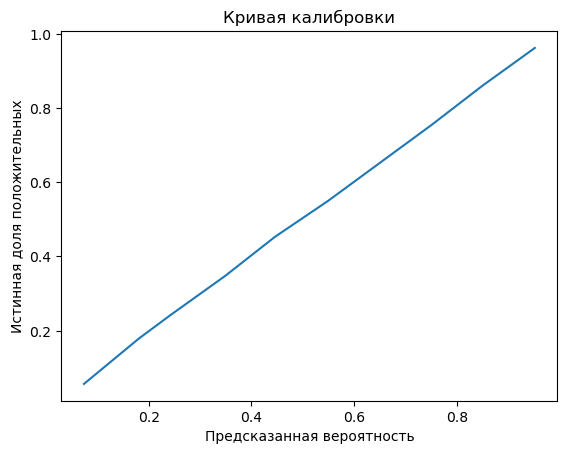

In [ ]:
# Калибровка модели
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(shap_df_pd['target'], test_predictions, n_bins=10)
plt.plot(prob_pred, prob_true)
plt.xlabel("Предсказанная вероятность")
plt.ylabel("Истинная доля положительных")
plt.title("Кривая калибровки")
plt.show()

# Анализ важности признаков
feature_importance = pd.DataFrame({
    'feature': cols,
    'importance': eee_lgb_model.feature_importances_
}).sort_values('importance', ascending=False)

In [ ]:
# Создаем датафрейм с ошибочными предсказаниями
wrong_predictions = shap_df_pd.assign(
    predicted_prob=test_predictions,
    predicted_class=(test_predictions > 0.5).astype(int)
).query(
    "(predicted_class == 1 and target == 0) or (predicted_class == 0 and target == 1)"
).copy()

# Добавляем разницу между предсказанием и фактическим значением
wrong_predictions['error_magnitude'] = np.abs(wrong_predictions['predicted_prob'] - wrong_predictions['target'])

print(f"Всего ошибочных предсказаний: {len(wrong_predictions)}")
print(f"Доля ошибок: {len(wrong_predictions)/len(shap_df_pd):.2%}")

Всего ошибочных предсказаний: 440326
Доля ошибок: 23.48%


In [ ]:
# Разделяем на False Positive и False Negative
fp = wrong_predictions[wrong_predictions['target'] == 0]
fn = wrong_predictions[wrong_predictions['target'] == 1]

print("\nРаспределение ошибок:")
print(f"False Positive (неверно предсказали 1): {len(fp)} ({len(fp)/len(wrong_predictions):.2%})")
print(f"False Negative (неверно предсказали 0): {len(fn)} ({len(fn)/len(wrong_predictions):.2%})")


Распределение ошибок:
False Positive (неверно предсказали 1): 100151 (22.74%)
False Negative (неверно предсказали 0): 340175 (77.26%)


In [ ]:
# Сначала выделим только оригинальные числовые признаки (исключая созданные временные колонки)
original_numerical_cols = [col for col in wrong_predictions.select_dtypes(include=np.number).columns 
                         if col not in ['predicted_prob', 'predicted_class', 'error_magnitude', 'target']]

print(f"Анализируем {len(original_numerical_cols)} числовых признаков")

# Сравнение средних значений
error_stats = wrong_predictions[original_numerical_cols].mean().to_frame('errors_mean')
global_stats = shap_df_pd[original_numerical_cols].mean().to_frame('global_mean')

result = (pd.concat([error_stats, global_stats], axis=1)
          .assign(difference=lambda x: x['errors_mean'] - x['global_mean'])
          .sort_values('difference', key=abs, ascending=False))

# Красивое отображение топ-10 признаков с наибольшими различиями
(top_diff_10 := result.head(10).style.background_gradient(
    subset=['difference'], cmap='coolwarm', vmin=-1, vmax=1
).format("{:.3f}"))

Анализируем 243 числовых признаков


c:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
c:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


,errors_mean,global_mean,difference
new_weekday_weekend_ratio,1954994.204,1705520.236,249473.968
total_spent_30d,10722.049,15349.570,-4627.521
sum_discount_price_click,17042.633,21014.750,-3972.117
user_id,5593987.704,5592275.104,1712.600
max_discount_price_order,1156.630,1293.846,-137.216
new_main_category_avg_price,809.695,836.784,-27.089
widget_22_count,38.452,54.069,-15.617
total_actions_30d,24.774,39.809,-15.035
avg_price_30d,677.379,669.278,8.101
widget_3_count,7.716,15.456,-7.740


c:\Users\Admin\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
c:\Users\Admin\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Admin\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


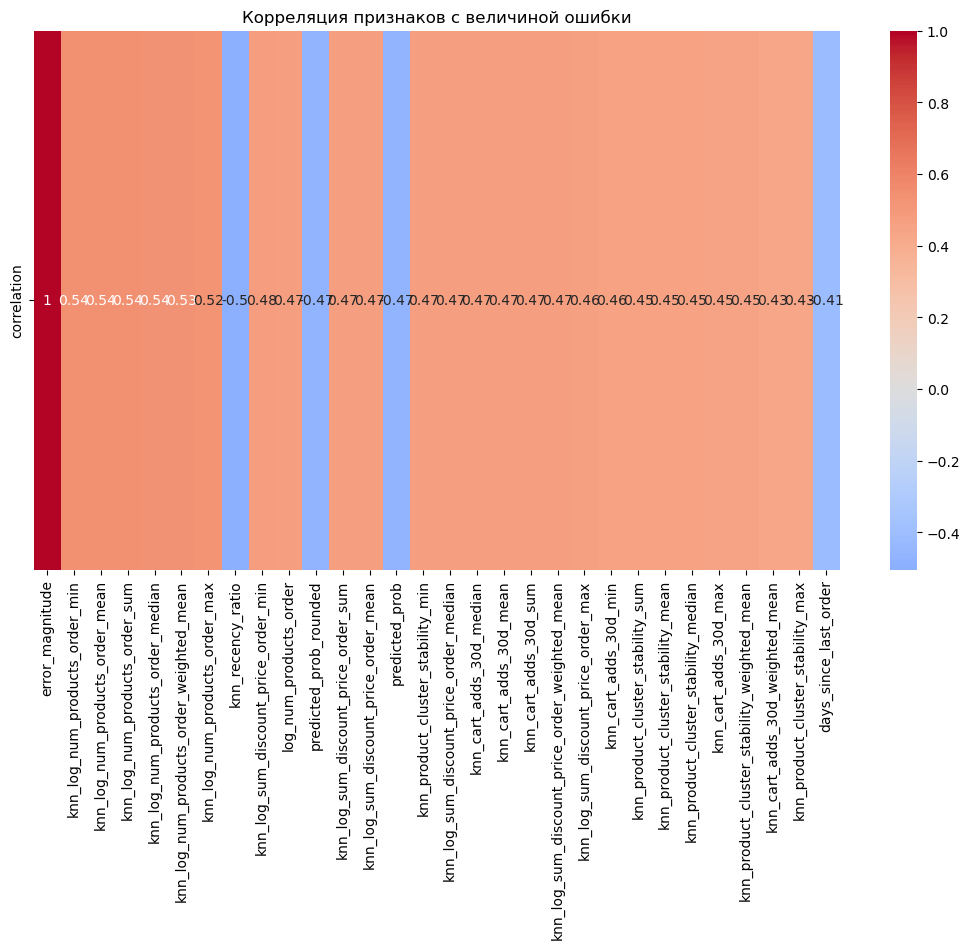

In [ ]:
# Признаки с наибольшей разницей между ошибочными и правильными предсказаниями
plt.figure(figsize=(13, 7))
sns.heatmap(
    wrong_predictions[numerical_cols].corrwith(wrong_predictions['error_magnitude']).to_frame('correlation').sort_values('correlation', key=abs, ascending=False).head(30).T,
    annot=True, cmap='coolwarm', center=0
)
plt.title('Корреляция признаков с величиной ошибки')
plt.show()

In [ ]:
# Самые "сильные" ошибки (где модель была наиболее уверена, но ошиблась)
top_errors = wrong_predictions.sort_values('error_magnitude', ascending=False).head(5)

print("\nТоп-5 самых уверенных, но ошибочных предсказаний:")
display(top_errors[['target', 'predicted_prob', 'error_magnitude'] + numerical_cols[:5]])


Топ-5 самых уверенных, но ошибочных предсказаний:


,target,predicted_prob,error_magnitude,user_id,target,num_products_click,sum_discount_price_click,days_since_last_click
810207,0,0.996954,0.996954,2057211,0,608.0,225518.0,0.0
18978,0,0.996703,0.996703,8569104,0,218.0,349317.0,0.0
437733,0,0.994844,0.994844,342722,0,207.0,115874.0,0.0
435161,0,0.993475,0.993475,5316413,0,155.0,35778.0,5.0
553687,0,0.992946,0.992946,3215244,0,204.0,89221.0,2.0


In [ ]:
# Сравнение распределений для ключевых признаков
key_features = error_stats.sort_values('difference', key=abs, ascending=False).index[:3]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, feat in zip(axes, key_features):
    sns.kdeplot(data=shap_df_pd, x=feat, label='Общее', ax=ax)
    sns.kdeplot(data=wrong_predictions, x=feat, label='Ошибки', ax=ax)
    ax.set_title(f'Распределение {feat}')
    ax.legend()
plt.tight_layout()
plt.show()

KeyError: 'difference'

In [ ]:
# Кластеризация ошибок для выявления паттернов
from sklearn.cluster import KMeans

# Выбираем топ-10 самых коррелированных с ошибками признаков
top_error_features = wrong_predictions[numerical_cols].corrwith(wrong_predictions['error_magnitude']).sort_values(key=abs, ascending=False).head(10).index.tolist()

# Кластеризация
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(wrong_predictions[top_error_features])

# Анализ кластеров
cluster_analysis = (wrong_predictions.assign(cluster=clusters)
                   .groupby('cluster')[top_error_features + ['error_magnitude']]
                   .mean())

print("\nХарактеристики кластеров ошибок:")
display(cluster_analysis.style.background_gradient(cmap='Blues'))

c:\Users\Admin\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
c:\Users\Admin\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Admin\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

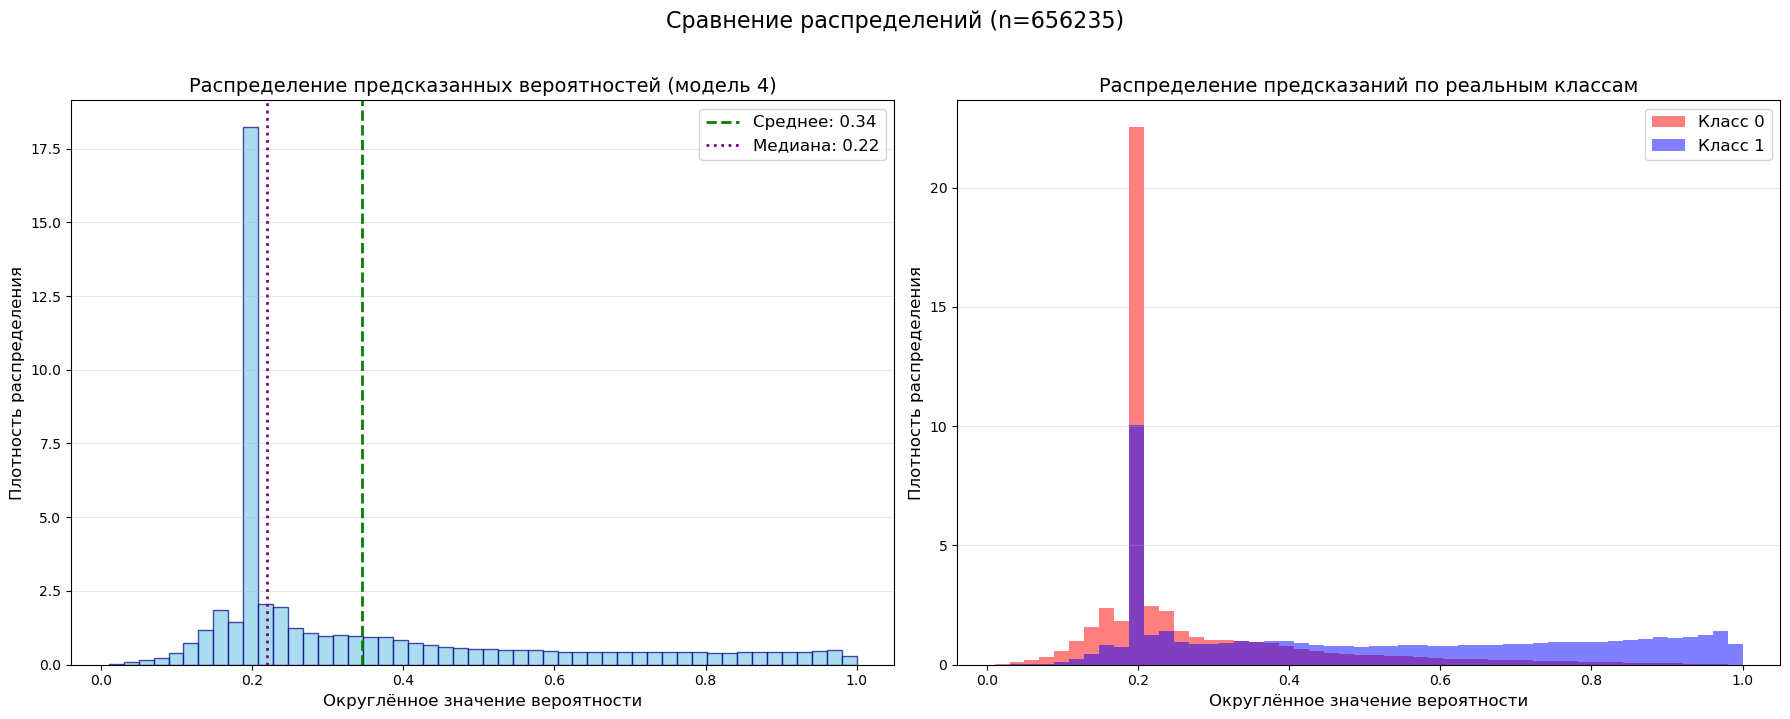

Среднее предсказание для класса 0: 0.259
Среднее предсказание для класса 1: 0.508


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Получаем предсказания
predict = lgb_model.predict_proba(lgb_val[cols])[:, 1]
predict_rounded = np.round(predict, 2)  # Округляем до 0.01

# Создаём фигуру с двумя подграфиками
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Первый график - распределение предсказаний
n1, bins1, patches1 = ax1.hist(predict_rounded, bins=50, color='skyblue', 
                              edgecolor='navy', alpha=0.7, density=True)

# Добавляем статистики
mean_val = np.mean(predict_rounded)
median_val = np.median(predict_rounded)
ax1.axvline(mean_val, color='green', linestyle='--', linewidth=2, label=f'Среднее: {mean_val:.2f}')
ax1.axvline(median_val, color='purple', linestyle=':', linewidth=2, label=f'Медиана: {median_val:.2f}')

ax1.set_title('Распределение предсказанных вероятностей (модель 4)', fontsize=14)
ax1.set_xlabel('Округлённое значение вероятности', fontsize=12)
ax1.set_ylabel('Плотность распределения', fontsize=12)
ax1.grid(axis='y', alpha=0.3)
ax1.legend(fontsize=12)

# Второй график - распределение реальных меток
target_values = lgb_val['target'].values
ax2.hist(predict_rounded[target_values == 0], bins=bins1, color='red', alpha=0.5, density=True, label='Класс 0')
ax2.hist(predict_rounded[target_values == 1], bins=bins1, color='blue', alpha=0.5, density=True, label='Класс 1')

ax2.set_title('Распределение предсказаний по реальным классам', fontsize=14)
ax2.set_xlabel('Округлённое значение вероятности', fontsize=12)
ax2.set_ylabel('Плотность распределения', fontsize=12)
ax2.grid(axis='y', alpha=0.3)
ax2.legend(fontsize=12)

# Общие настройки
plt.suptitle(f'Сравнение распределений (n={len(predict)})', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Дополнительная статистика
print(f"Среднее предсказание для класса 0: {np.mean(predict_rounded[target_values == 0]):.3f}")
print(f"Среднее предсказание для класса 1: {np.mean(predict_rounded[target_values == 1]):.3f}")

In [ ]:
uncertain_mask = (predict_rounded >= 0.15) & (predict_rounded <= 0.25)
problem_samples = lgb_val[uncertain_mask].copy()
problem_samples['predict'] = predict_rounded[uncertain_mask]

In [ ]:
import shap

# Инициализируем explainer на всей модели
explainer = shap.TreeExplainer(base_models[4])

# Вычисляем SHAP только для проблемных объектов
shap_values_problem = explainer.shap_values(problem_samples[feature_subsets[4]])

c:\Users\Admin\anaconda3\Lib\site-packages\shap\explainers\_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


In [ ]:
class1_problems = problem_samples[problem_samples['target'] == 1]
class0_problems = problem_samples[problem_samples['target'] == 0]

import numpy as np
import pandas as pd
import shap

# Убедимся, что shap_values_problem имеет правильную структуру
if isinstance(shap_values_problem, list):
    print(f"SHAP значений для класса 0: {np.array(shap_values_problem[0]).shape}")
    print(f"SHAP значений для класса 1: {np.array(shap_values_problem[1]).shape}")
    shap_matrix = np.array(shap_values_problem[1])  # Используем SHAP для класса 1
else:
    shap_matrix = np.array(shap_values_problem)  # Если SHAP значения не в списке

print(f"Размерность матрицы признаков: {class1_problems[feature_subsets[4]].shape}")

Размерность матрицы признаков: (69814, 204)


In [ ]:
print(f"Тип shap_values_problem: {type(shap_values_problem)}")
if isinstance(shap_values_problem, list):
    print(f"SHAP для класса 0: {shap_values_problem[0].shape}")
    print(f"SHAP для класса 1: {shap_values_problem[1].shape}")

Тип shap_values_problem: <class 'numpy.ndarray'>


In [ ]:
# Преобразуем данные в правильный формат
shap_df = pd.DataFrame(shap_matrix, columns=feature_subsets[4])
features_df = class1_problems[feature_subsets[4]].reset_index(drop=True)

# Убедимся, что размерности совпадают
assert len(shap_df) == len(features_df), "Размерности SHAP и признаков не совпадают!"

# Строим summary plot с проверкой
try:
    shap.summary_plot(
        shap_df.values, 
        features_df,
        plot_type='dot',
        max_display=10,
        title='Влияние признаков на класс 1 в проблемных случаях'
    )
except Exception as e:
    print(f"Ошибка при построении графика: {str(e)}")
    print("Пробуем альтернативный вариант...")
    
    # Альтернатива через bar plot
    shap.plots.bar(
        shap.Explanation(
            values=shap_df.values,
            base_values=np.repeat(explainer.expected_value[1], len(shap_df)),
            data=features_df.values,
            feature_names=feature_subsets[4]
        ),
        max_display=10
    )

AssertionError: Размерности SHAP и признаков не совпадают!

In [ ]:
class0_problems = problem_samples[problem_samples['target'] == 0]

# Сводный анализ через summary plot
shap.summary_plot(
    shap_values_problem[0], 
    class0_problems[feature_subsets[4]],
    plot_type='bar',
    max_display=15
)

In [ ]:
# SHAP для нормальных предсказаний класса 1
normal_class1 = lgb_val[(predict_rounded > 0.7) & (lgb_val['target'] == 1)]
shap_normal = explainer.shap_values(normal_class1[feature_subsets[4]])

# Сравниваем средние абсолютные SHAP-значения
problem_importance = np.abs(shap_values_problem[1]).mean(0)
normal_importance = np.abs(shap_normal[1]).mean(0)

# Разница в важности признаков
importance_diff = pd.DataFrame({
    'feature': feature_subsets[4],
    'problem_importance': problem_importance,
    'normal_importance': normal_importance,
    'difference': problem_importance - normal_importance
}).sort_values('difference', ascending=False)

print(importance_diff.head(10))

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

top_problem_feature = importance_diff.iloc[0]['feature']

PartialDependenceDisplay.from_estimator(
    base_models[4], 
    lgb_val[feature_subsets[4]], 
    features=[top_problem_feature],
    kind='both'  # и средний эффект, и индивидуальный
)
plt.show()